In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),
                         std=(0.5,))])

In [3]:
train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform=transform,
    download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 135224914.28it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 44948309.40it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 41788620.92it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4108373.68it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
len(train_dataset)

60000

In [5]:
batch_size = 128
data_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

In [6]:
D = nn.Sequential(
    nn.Linear(784, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 256),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 1),
)

In [7]:
latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256, momentum=0.7),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512, momentum=0.7),
    nn.Linear(512, 1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024, momentum=0.7),
    nn.Linear(1024, 784),
    nn.Tanh()
)

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
D = D.to(device)
G = G.to(device)

In [9]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.001, betas=(0.5, 0.999))
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.001, betas=(0.5, 0.999))

In [10]:
def scale_image(img):
  out = (img + 1) / 2
  return out

In [11]:
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [12]:
ones_ = torch.ones(batch_size, 1).to(device)
zeros_ = torch.zeros(batch_size, 1).to(device)

d_losses = []
g_losses = []

epochs = 200

for ep in range(epochs):
  for inputs, _ in data_loader:

    n = inputs.size(0)
    inputs = inputs.reshape(n, 784).to(device)

    ones = ones_[:n]
    zeros = zeros_[:n]

    real_outputs = D(inputs)
    d_loss_real = criterion(real_outputs, ones)

    noise = torch.randn(n, latent_dim).to(device)
    fake_images = G(noise)
    fake_outputs = D(fake_images)
    d_loss_fake = criterion(fake_outputs, zeros)

    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()
    d_loss.backward()
    d_optimizer.step()

    for _ in range(2):
      noise = torch.randn(n, latent_dim).to(device)
      fake_images = G(noise)
      fake_outputs = D(fake_images)

      g_loss = criterion(fake_outputs, ones)

      d_optimizer.zero_grad()
      g_optimizer.zero_grad()
      g_loss.backward()
      g_optimizer.step()

    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

  print(f'Epoch: [ {ep+1} / {epochs}] | D. Loss: {d_loss.item():.4f} | G. Loss: {g_loss.item():.4f}')

  fake_images = fake_images.reshape(-1, 1, 28, 28)
  save_image(scale_image(fake_images), f'gan_images/{ep+1}.png')

Epoch: [ 1 / 200] | D. Loss: 0.6804 | G. Loss: 0.6682
Epoch: [ 2 / 200] | D. Loss: 0.6629 | G. Loss: 0.7932
Epoch: [ 3 / 200] | D. Loss: 0.6634 | G. Loss: 0.6453
Epoch: [ 4 / 200] | D. Loss: 0.6847 | G. Loss: 0.7164
Epoch: [ 5 / 200] | D. Loss: 0.6781 | G. Loss: 0.6886
Epoch: [ 6 / 200] | D. Loss: 0.6944 | G. Loss: 0.7191
Epoch: [ 7 / 200] | D. Loss: 0.6612 | G. Loss: 0.8047
Epoch: [ 8 / 200] | D. Loss: 0.6748 | G. Loss: 0.7922
Epoch: [ 9 / 200] | D. Loss: 0.6612 | G. Loss: 0.7400
Epoch: [ 10 / 200] | D. Loss: 0.6826 | G. Loss: 0.7174
Epoch: [ 11 / 200] | D. Loss: 0.6790 | G. Loss: 0.6824
Epoch: [ 12 / 200] | D. Loss: 0.7040 | G. Loss: 0.7220
Epoch: [ 13 / 200] | D. Loss: 0.6859 | G. Loss: 0.6776
Epoch: [ 14 / 200] | D. Loss: 0.6957 | G. Loss: 0.7490
Epoch: [ 15 / 200] | D. Loss: 0.6824 | G. Loss: 0.6833
Epoch: [ 16 / 200] | D. Loss: 0.6957 | G. Loss: 0.7104
Epoch: [ 17 / 200] | D. Loss: 0.6845 | G. Loss: 0.7687
Epoch: [ 18 / 200] | D. Loss: 0.6783 | G. Loss: 0.7688
Epoch: [ 19 / 200] 

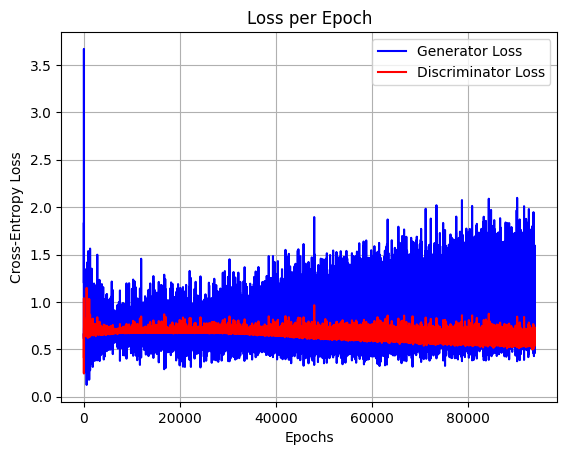

In [13]:
fig, ax = plt.subplots()
ax.plot(g_losses, 'blue', label='Generator Loss')
ax.plot(d_losses, 'red', label='Discriminator Loss')
ax.set(title='Loss per Epoch',
       ylabel='Cross-Entropy Loss',
       xlabel='Epochs')
ax.legend()
ax.grid()
plt.show()

In [14]:
torch.save(G.state_dict, 'image_generator.pt')
torch.save(D.state_dict, 'discriminator.pt')

In [57]:
noise = torch.randn(100, latent_dim).to(device)
with torch.no_grad():
  images = G(noise)
  outputs = D(images)

In [58]:
best_idx = torch.argsort(outputs.reshape(-1,))[:4]
best_images = images[best_idx,:]

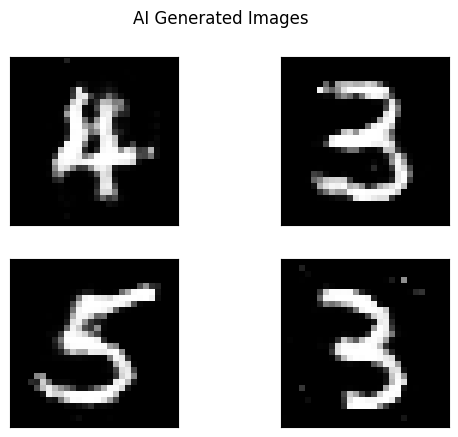

In [59]:
best_images = scale_image(best_images.reshape(-1, 28, 28)).to('cpu').numpy()
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2)
ax1.imshow(best_images[0,:,:], cmap='gray')
ax1.set(xticks=([]), yticks=([]))
ax2.imshow(best_images[1,:,:], cmap='gray')
ax2.set(xticks=([]), yticks=([]))
ax3.imshow(best_images[2,:,:], cmap='gray')
ax3.set(xticks=([]), yticks=([]))
ax4.imshow(best_images[3,:,:], cmap='gray')
ax4.set(xticks=([]), yticks=([]))
plt.suptitle('AI Generated Images')
plt.show()